# Telco Project

- What are the main features driving customer churn at Telco?

- Is tenure indicative of churn? When are customers most likely to leave?

- Are monthly charges related to churn, and if so, how?

- What additional features keep customers from churning?

- How does contract type affect customer churn?

## Acquire and prepare data

In [1]:
import pandas as pd
import numpy as np
import acquire
import prepare
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
def new_telco_data():
    '''
    This function reads the telco data from the Codeup db into a df.
    '''
    sql_query = """
                select * from customers
                join contract_types using (contract_type_id)
                join internet_service_types using (internet_service_type_id)
                join payment_types using (payment_type_id)
                """
    
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, acquire.get_connection('telco_churn'))
    
    return df

In [3]:
def get_telco_data():
    '''
    This function reads in telco data from Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    if os.path.isfile('telco.csv'):
        
        # If csv file exists read in data from csv file.
        df = pd.read_csv('telco.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame
        df = new_telco_data()
        
        # Cache data
        df.to_csv('telco.csv')
        
    return df

In [4]:
import os
telco = get_telco_data()

In [5]:
telco.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


In [6]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [7]:
telco.describe()

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2.315633,1.872923,1.690473,0.162147,32.371149,64.761692
std,1.148907,0.737796,0.833755,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,2.000000,1.000000,0.000000,29.000000,70.350000
75%,3.000000,2.000000,2.000000,0.000000,55.000000,89.850000
max,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000


## Initial Analysis of Dataset

- The descriptive statistics of the telco dataset show that further preparation is required for EDA. The data has no nulls and contains many features that are categorical, but are in string format. 

- Gender is evenly distributed and can likely be removed from the dataset. Roughly half of the customers have a partner, 38 percent have dependents, and 16 percent are senior citizens.

- The average tenure is 32 months, 59 percent use paperless billing. Is this the same data as the automatic payment vs. manual payments? 26.5 percent of customers have churned, average monthly charges are 64.76, and 90 percent of customers have phone service.

## Further Preparation of Data

- I am encoding the categorical features using 1 for yes and 0 for no. This will allow me to calculate proportions for each feature.

- For columns that are in string format, I will get the value counts of each to see if there are ways to clean the data further. 

In [8]:
# encoding categorical variables

telco['gender'] = telco.gender.map({'Female': 0, 'Male': 1})

telco['partner'] = telco.partner.map({'Yes': 1, 'No': 0})

telco['dependents'] = telco.dependents.map({'Yes': 1, 'No': 0})

telco['phone_service'] = telco.phone_service.map({'Yes': 1, 'No': 0})

telco['paperless_billing'] = telco.paperless_billing.map({'Yes': 1, 'No': 0})

telco['churn'] = telco.churn.map({'Yes': 1, 'No': 0})

In [9]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   int64  
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   int64  
 7   dependents                7043 non-null   int64  
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   int64  
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

- the multiple_lines column has three values: Yes, No, and No phone service. Since phone_service already captures whether or not a person has phone service, I will combine the No and No phone service values into one value, No, and encode the column.

In [10]:
# multiple_lines has two separate columns for No: No and No phone service. I am combining these into one No value
# for encoding and analysis.

telco['multiple_lines'] = telco.multiple_lines.str.replace('No phone service', 'No')

In [11]:
telco.multiple_lines.value_counts()

No     4072
Yes    2971
Name: multiple_lines, dtype: int64

In [12]:
telco['multiple_lines'] = telco.multiple_lines.map({'Yes': 1, 'No': 0})

In [13]:
telco.payment_type.value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_type, dtype: int64

- The payment_type column has four values, but they can be combined into two values, manual and automatic, and encoded as well.

In [14]:
# replacing the two manual payment types into one variable, 'manual'

telco['payment_type'] = telco.payment_type.str.replace('Electronic check','manual').str.replace('Mailed check','manual')

In [15]:
# replacing the two automatic payment types into one variable, 'auto'

telco['payment_type'] = telco.payment_type.str.replace('(','').str.replace(')', '').str.replace('Bank transfer automatic', 'auto').str.replace('Credit card automatic', 'auto')

/var/folders/5g/xrhpsnj56_v3scw9s4trbgxc0000gn/T/ipykernel_6582/1364325303.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  telco['payment_type'] = telco.payment_type.str.replace('(','').str.replace(')', '').str.replace('Bank transfer automatic', 'auto').str.replace('Credit card automatic', 'auto')


In [16]:
telco.payment_type.value_counts()

manual    3977
auto      3066
Name: payment_type, dtype: int64

In [17]:
pd.crosstab(telco.streaming_tv, telco.streaming_movies)

streaming_movies,No,No internet service,Yes
streaming_tv,,,
No,2018,0,792
No internet service,0,1526,0
Yes,767,0,1940


- The streaming_tv and streaming_movies columns can be converted into two values like like the multiple_lines columns because it the No internet service value is already captured in the internet_service_type_id column.

In [18]:
telco['streaming_tv'] = telco.streaming_tv.str.replace('No internet service','No')
telco['streaming_movies'] = telco.streaming_movies.str.replace('No internet service', 'No')

In [19]:
telco.streaming_movies.value_counts(), telco.streaming_tv.value_counts()

(No     4311
 Yes    2732
 Name: streaming_movies, dtype: int64,
 No     4336
 Yes    2707
 Name: streaming_tv, dtype: int64)

- All the extra feature columns for internet service will be changed into two values instead of three and then encoded.

In [20]:
telco['online_security'] = telco.online_security.str.replace('No internet service', 'No')
telco['online_backup'] = telco.online_backup.str.replace('No internet service', 'No')
telco['device_protection'] = telco.device_protection.str.replace('No internet service', 'No')
telco['tech_support'] = telco.tech_support.str.replace('No internet service', 'No')

In [21]:
telco.online_security.value_counts(), telco.online_backup.value_counts(), telco.device_protection.value_counts(), telco.tech_support.value_counts()

(No     5024
 Yes    2019
 Name: online_security, dtype: int64,
 No     4614
 Yes    2429
 Name: online_backup, dtype: int64,
 No     4621
 Yes    2422
 Name: device_protection, dtype: int64,
 No     4999
 Yes    2044
 Name: tech_support, dtype: int64)

- Now we have yes or no values for all columns that are associated with internet service and phone service.

In [22]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   int64  
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   int64  
 7   dependents                7043 non-null   int64  
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   int64  
 10  multiple_lines            7043 non-null   int64  
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

- total_charges is a numeric value that is in string format. I will turn the column into a float64 datatype.

In [23]:
telco['total_charges'] = telco.total_charges.str.replace('$','').str.replace(',','').str.replace(' ','').fillna(0)
telco['total_charges'] = pd.to_numeric(telco.total_charges)

/var/folders/5g/xrhpsnj56_v3scw9s4trbgxc0000gn/T/ipykernel_6582/989436481.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  telco['total_charges'] = telco.total_charges.str.replace('$','').str.replace(',','').str.replace(' ','').fillna(0)


In [24]:
telco.dtypes

payment_type_id               int64
internet_service_type_id      int64
contract_type_id              int64
customer_id                  object
gender                        int64
senior_citizen                int64
partner                       int64
dependents                    int64
tenure                        int64
phone_service                 int64
multiple_lines                int64
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
paperless_billing             int64
monthly_charges             float64
total_charges               float64
churn                         int64
contract_type                object
internet_service_type        object
payment_type                 object
dtype: object

- The datatypes look good; I will now split the data.

In [25]:
# create train, validate, test datasets using the split_data function from the prepare.py file

train_telco, validate_telco, test_telco = prepare.split_data(telco, 'churn')

In [26]:
train_telco.shape, validate_telco.shape, test_telco.shape

((4225, 24), (1409, 24), (1409, 24))

- The datasets are split 60/20/20 and stratified on 'churn'

In [27]:
train_telco.describe()

,payment_type_id,internet_service_type_id,contract_type_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,paperless_billing,monthly_charges,total_charges,churn
count,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4225.000000,4220.000000,4225.000000
mean,2.320000,1.878107,1.692544,0.507456,0.163314,0.493728,0.298225,32.736568,0.905325,0.426509,0.595976,64.975325,2317.808898,0.265325
std,1.157093,0.735695,0.838753,0.500004,0.369695,0.500020,0.457533,24.518294,0.292800,0.494628,0.490760,30.184347,2277.970403,0.441559
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.850000,0.000000
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,35.750000,416.200000,0.000000
50%,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,30.000000,1.000000,0.000000,1.000000,70.550000,1415.425000,0.000000
75%,3.000000,2.000000,2.000000,1.000000,0.000000,1.000000,1.000000,56.000000,1.000000,1.000000,1.000000,90.050000,3858.900000,1.000000
max,4.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,1.000000,118.750000,8684.800000,1.000000


In [28]:
train_telco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4225 entries, 621 to 5771
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           4225 non-null   int64  
 1   internet_service_type_id  4225 non-null   int64  
 2   contract_type_id          4225 non-null   int64  
 3   customer_id               4225 non-null   object 
 4   gender                    4225 non-null   int64  
 5   senior_citizen            4225 non-null   int64  
 6   partner                   4225 non-null   int64  
 7   dependents                4225 non-null   int64  
 8   tenure                    4225 non-null   int64  
 9   phone_service             4225 non-null   int64  
 10  multiple_lines            4225 non-null   int64  
 11  online_security           4225 non-null   object 
 12  online_backup             4225 non-null   object 
 13  device_protection         4225 non-null   object 
 14  tech_s

### Univariate analysis

<AxesSubplot:xlabel='churn', ylabel='count'>

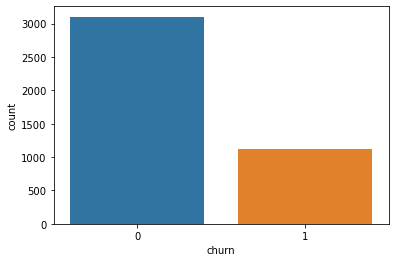

In [29]:
# graphical representation of churn

sns.countplot(x='churn', data=train_telco)

In [30]:
train_telco.churn.describe()

count    4225.000000
mean        0.265325
std         0.441559
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: churn, dtype: float64

- Approximately 26.5 percent of customers have churned.

<AxesSubplot:xlabel='tenure', ylabel='Count'>

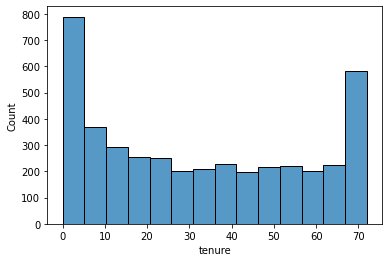

In [31]:
# histogram of customer tenure

sns.histplot(x='tenure', data=train_telco)

In [32]:
train_telco.tenure.describe()

count    4225.000000
mean       32.736568
std        24.518294
min         0.000000
25%         9.000000
50%        30.000000
75%        56.000000
max        72.000000
Name: tenure, dtype: float64

- Half of the customers have a tenure of 30 months or less; the average tenure is 32.7 months

<AxesSubplot:xlabel='monthly_charges', ylabel='Count'>

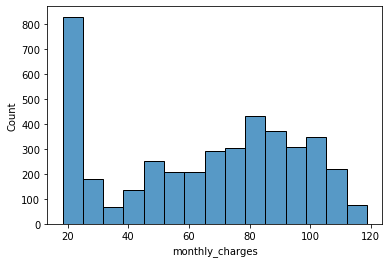

In [33]:
# histogram of customer monthly charges; half of the customers pay 30 dollars or less

sns.histplot(x=train_telco.monthly_charges)

In [34]:
train_telco.monthly_charges.describe()

count    4225.000000
mean       64.975325
std        30.184347
min        18.250000
25%        35.750000
50%        70.550000
75%        90.050000
max       118.750000
Name: monthly_charges, dtype: float64

- The average monthly charge per customer is around 65 dollars; charges range from 18.25 to 118.75 per month.

<AxesSubplot:xlabel='senior_citizen', ylabel='count'>

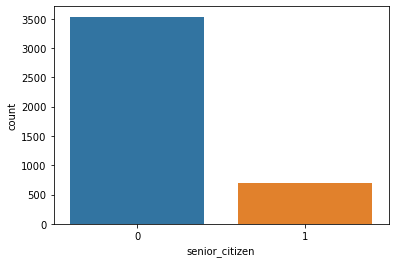

In [35]:
# bar graph of how many customers are senior citizens

sns.countplot(x=train_telco.senior_citizen)

In [36]:
train_telco.senior_citizen.describe()

count    4225.000000
mean        0.163314
std         0.369695
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: senior_citizen, dtype: float64

- 16 percent of customers are senior citizens

<AxesSubplot:xlabel='internet_service_type', ylabel='count'>

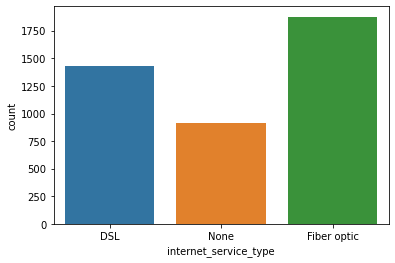

In [37]:
# bar graph of internet service types; Fiber optic is the most popular type

sns.countplot(x='internet_service_type', data=train_telco)

In [38]:
train_telco.internet_service_type.value_counts()

Fiber optic    1876
DSL            1432
None            917
Name: internet_service_type, dtype: int64

- Fiber optic service is the most popular type, followed by DSL; approximately 22 percent of customers do not have internet

<AxesSubplot:xlabel='payment_type', ylabel='count'>

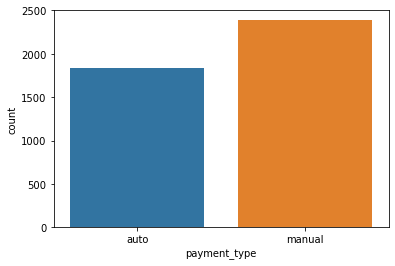

In [39]:
# bar graph of payment types; more people pay by check than bank transfer/credit card

sns.countplot(x='payment_type', data=train_telco)

In [40]:
train_telco.payment_type.value_counts()

manual    2385
auto      1840
Name: payment_type, dtype: int64

- More customers use manual payments than automatic payments.

<AxesSubplot:xlabel='contract_type', ylabel='count'>

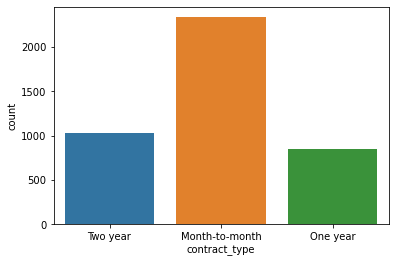

In [41]:
# bar graph of contract types; most customers are on a month-to-month contract type

sns.countplot(x='contract_type', data=train_telco)

In [42]:
train_telco.contract_type.value_counts()

Month-to-month    2335
Two year          1036
One year           854
Name: contract_type, dtype: int64

- More customers are on a month-to-month basis than on one-year and two-year contracts combined.

<AxesSubplot:xlabel='phone_service', ylabel='count'>

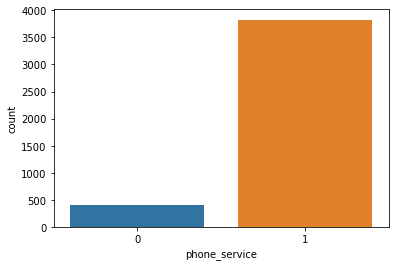

In [43]:
# bar graph of phone service; most customers have phone service

sns.countplot(x='phone_service', data=train_telco)

In [44]:
train_telco.phone_service.value_counts()

1    3825
0     400
Name: phone_service, dtype: int64

- The vast majority of customers have phone service.

<AxesSubplot:xlabel='multiple_lines', ylabel='count'>

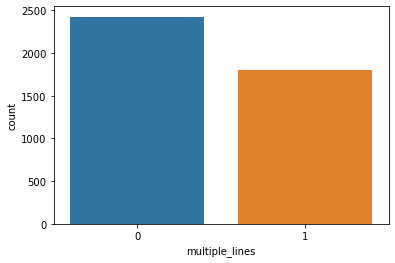

In [45]:
# bar graph of whether or not customers have more than one line; more customers have either one line or no phone service

sns.countplot(x='multiple_lines', data=train_telco)

In [46]:
train_telco.multiple_lines.value_counts()

0    2423
1    1802
Name: multiple_lines, dtype: int64

- Approximately 57 percent of customers do not have multiple lines.

<AxesSubplot:xlabel='paperless_billing', ylabel='count'>

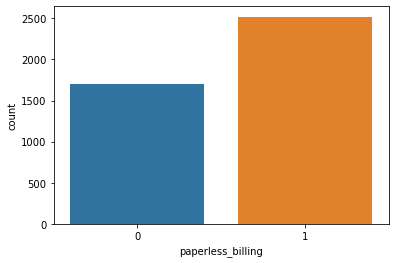

In [47]:
# bar graph of paperless billing; more customers are signed up for paperless billing than not

sns.countplot(x='paperless_billing', data=train_telco)

In [48]:
train_telco.paperless_billing.describe()

count    4225.000000
mean        0.595976
std         0.490760
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: paperless_billing, dtype: float64

- Approximately 60 percent of customers use paperless billing.

<AxesSubplot:xlabel='streaming_tv', ylabel='count'>

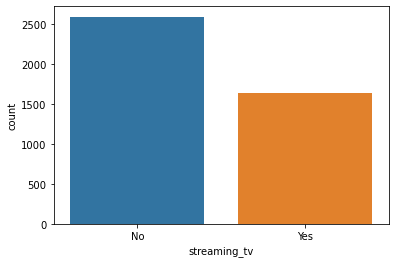

In [49]:
# bar graph of the numbers of customers who do and do not have streaming tv

sns.countplot(x=train_telco.streaming_tv)

In [50]:
train_telco.streaming_tv.value_counts()

No     2590
Yes    1635
Name: streaming_tv, dtype: int64

- 61 percent of customers do not have streaming tv.

<AxesSubplot:xlabel='streaming_movies', ylabel='count'>

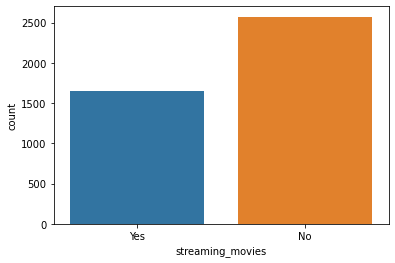

In [51]:
# bar graph of how many customers do and do not have streaming movies

sns.countplot(x=train_telco.streaming_movies)

In [52]:
train_telco.streaming_movies.value_counts()

No     2571
Yes    1654
Name: streaming_movies, dtype: int64

- Approximately 61 percent of customers do not have streaming movies.

<AxesSubplot:xlabel='online_security', ylabel='count'>

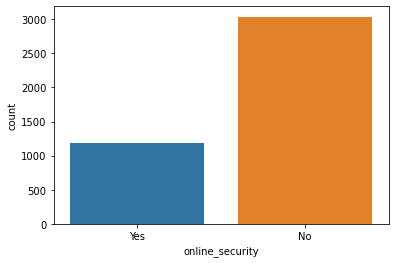

In [53]:
# bar graph of customer counts for online security

sns.countplot(x=train_telco.online_security)

In [54]:
train_telco.online_security.value_counts()

No     3034
Yes    1191
Name: online_security, dtype: int64

- Approximately 72 percent of customers do not have online security.

<AxesSubplot:xlabel='device_protection', ylabel='count'>

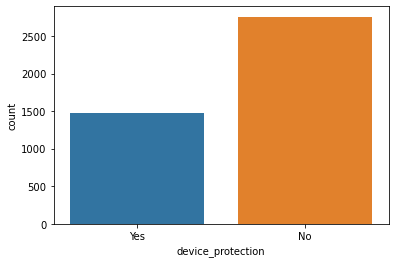

In [55]:
# bar graph of customer counts for device protection

sns.countplot(x=train_telco.device_protection)

In [56]:
train_telco.device_protection.value_counts()

No     2755
Yes    1470
Name: device_protection, dtype: int64

- Approximately 65 percent of customers do not have device protection.

<AxesSubplot:xlabel='tech_support', ylabel='count'>

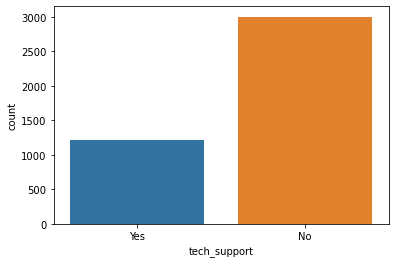

In [57]:
# bar graph for customer counts for tech support

sns.countplot(x=train_telco.tech_support)

In [58]:
train_telco.tech_support.value_counts()

No     3003
Yes    1222
Name: tech_support, dtype: int64

- Approximately 71 percent of customers do not have tech support.

<AxesSubplot:xlabel='online_backup', ylabel='count'>

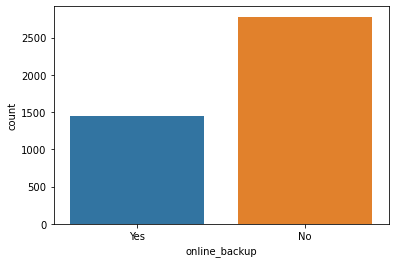

In [59]:
# bar graph of customer counts for online backup

sns.countplot(x=train_telco.online_backup)

In [60]:
train_telco.online_backup.value_counts()

No     2780
Yes    1445
Name: online_backup, dtype: int64

- Approximately 66 percent of customers do not have online backup.

<AxesSubplot:xlabel='partner', ylabel='count'>

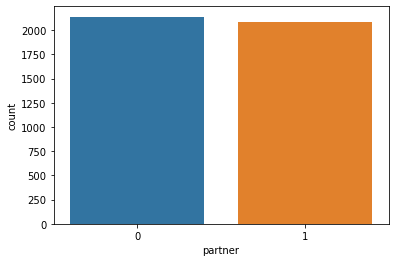

In [61]:
# bar graph of customer counts for partner

sns.countplot(x=train_telco.partner)

In [62]:
train_telco.partner.value_counts()

0    2139
1    2086
Name: partner, dtype: int64

- Customers with a partner and customers without a partner are almost evenly split.

<AxesSubplot:xlabel='dependents', ylabel='count'>

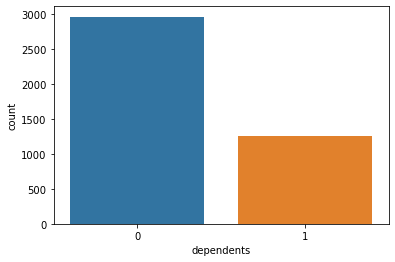

In [63]:
# bar graph of customer counts for dependents

sns.countplot(x=train_telco.dependents)

In [64]:
train_telco.dependents.value_counts()

0    2965
1    1260
Name: dependents, dtype: int64

- Approximately 70 percent of customers do not have dependents.

#### Findings:

- 26.5 percent of customers churned

- Average tenure is 32.7 months, but most customers are between 0-5 and 65-70 months.

- Average monthly charge is 65, but most customers pay between 18-25

- 16 percent of customers are senior citizens

- Fiber optic is the most popular internet service type

- more customers make manual payments than automatic payments

- More customers have a month-to-month contract type than two-year and one-year contracts combined

- Most customers have phone service, and more customers have only one line rather than multiple lines

- 59.6 percent of customers use paperless billing

- There are more customers who do not have additional features than do (streaming, protection, support, etc.)

- Customers are almost evenly split between having a partner and not, but more customers do not have dependents.



### Bivariate analysis

<AxesSubplot:xlabel='monthly_charges', ylabel='Count'>

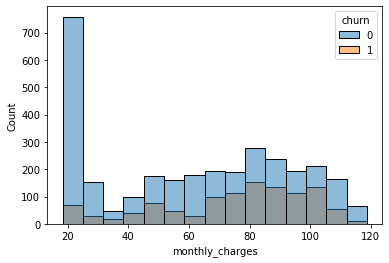

In [65]:
# histplot of monthly charges and churn; average monthly charge for customers who churned is around 75 dollars

sns.histplot(x=train_telco.monthly_charges, hue=train_telco.churn)

In [66]:
train_telco.monthly_charges[train_telco.churn==1].describe()

count    1121.000000
mean       74.885772
std        24.519717
min        18.850000
25%        57.550000
50%        79.900000
75%        94.250000
max       118.350000
Name: monthly_charges, dtype: float64

In [67]:
# correlation of monthly charges to churn using Pearson's r
# there is a relationship between monthly charges and churn, but the strength of the correlation is small

corr, p = stats.pearsonr(train_telco.monthly_charges, train_telco.churn)
corr, p

(0.19733529945537656, 2.3330208636155277e-38)

In [68]:
# H0: There is no difference in monthly charges between customers who churn and customers who do not churn.
# Ha: There is a difference in monthly charges between customers who churn and customers who do not churn.

In [69]:
x = train_telco.monthly_charges[train_telco.churn == 1]
y = train_telco.monthly_charges[train_telco.churn == 0]

In [70]:
stat, p = stats.mannwhitneyu(x,y)
stat, p

(2165487.5, 5.026574674370433e-34)

In [71]:
alpha = 0.05

if p < alpha:
    print('We reject the null hypothesis that there is no difference in monthly charges between customers who churn and customers who do not churn.')
else:
    print('We fail to reject the null hypothesis that there is no difference in monthly charges between customers who churn and customers who do not churn.')

We reject the null hypothesis that there is no difference in monthly charges between customers who churn and customers who do not churn.


<AxesSubplot:xlabel='tenure', ylabel='Count'>

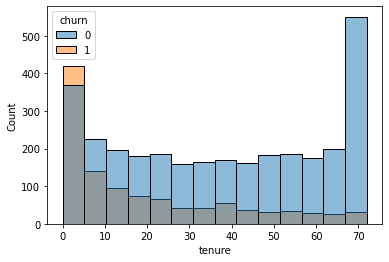

In [72]:
# histogram of tenure and churn; most churn occurs within the first 15 months

sns.histplot(x=train_telco.tenure, hue=train_telco.churn)

In [73]:
train_telco.tenure[train_telco.churn==1].describe()

count    1121.000000
mean       18.871543
std        19.842224
min         1.000000
25%         2.000000
50%        11.000000
75%        31.000000
max        72.000000
Name: tenure, dtype: float64

In [74]:
# correlation calculation for tenure and churn; the two variables are correlated with an r of .34

corr, p = stats.pearsonr(train_telco.tenure, train_telco.churn)
corr, p

(-0.3398785497306553, 9.804162371170059e-115)

In [75]:
# H0: There is no difference in tenure between customers who churn and customers who do not churn.
# Ha: There is a difference in tenure between customers who churn and customers who do not churn.

In [76]:
x2 = train_telco.tenure[train_telco.churn == 1]
y2 = train_telco.tenure[train_telco.churn == 0]

In [77]:
stat2, p2 = stats.mannwhitneyu(x2,y2)
stat2, p2

(937682.5, 2.646232201899285e-116)

In [78]:
alpha = 0.05

if p < alpha:
    print('We reject the null hypothesis that there is no difference in tenure between customers who churn and customers who do not churn.')
else:
    print('We fail to reject the null hypothesis that there is no difference in tenure between customers who churn and customers who do not churn.')

We reject the null hypothesis that there is no difference in tenure between customers who churn and customers who do not churn.


<AxesSubplot:xlabel='senior_citizen', ylabel='count'>

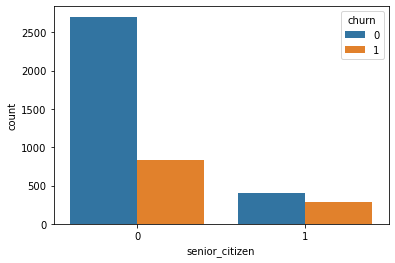

In [79]:
# bar graph of the relationship between senior citizen status and churn

sns.countplot(x=train_telco.senior_citizen, hue=train_telco.churn)

In [80]:
pd.crosstab(train_telco.senior_citizen, train_telco.churn)

churn,0,1
senior_citizen,,
0,2702,833
1,402,288


In [81]:
# chi2 test for the relationship between senior citizen status and churn shows that there is a relationship

observed = pd.crosstab(train_telco.senior_citizen, train_telco.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [82]:
print('Observed')
print(observed.values)
print('\nExpected')
print(expected.astype(int))
print('\n----')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[2702  833]
 [ 402  288]]

Expected
[[2597  937]
 [ 506  183]]

----
chi^2 = 96.9007
p     = 0.0000


<AxesSubplot:xlabel='internet_service_type', ylabel='count'>

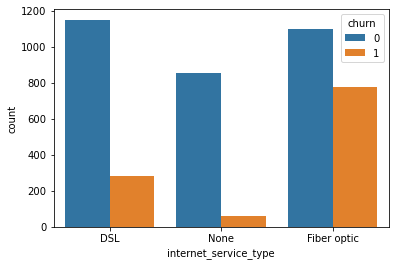

In [83]:
# bar graph of the number of people who churn based on internet service type; people with fiber optic internet churn
# more than DSL and no internet customers

sns.countplot(x='internet_service_type', hue='churn', data=train_telco)

In [84]:
pd.crosstab(train_telco.internet_service_type, train_telco.churn)

churn,0,1
internet_service_type,,
DSL,1149,283
Fiber optic,1100,776
None,855,62


In [85]:
# chi2 test for the relationship between internet service type and churn shows that there is a relationship

observed = pd.crosstab(train_telco.internet_service_type, train_telco.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [86]:
print('Observed')
print(observed.values)
print('\nExpected')
print(expected.astype(int))
print('\n----')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[1149  283]
 [1100  776]
 [ 855   62]]

Expected
[[1052  379]
 [1378  497]
 [ 673  243]]

----
chi^2 = 429.2846
p     = 0.0000


<AxesSubplot:xlabel='payment_type', ylabel='count'>

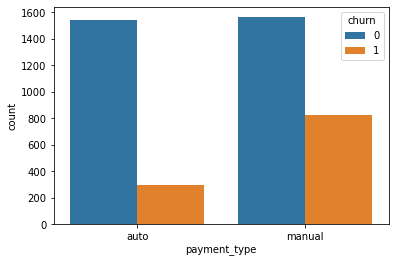

In [87]:
# bar graph of the relationship between payment type and churn

sns.countplot(x='payment_type', hue='churn', data=train_telco)

In [88]:
pd.crosstab(train_telco.payment_type, train_telco.churn)

churn,0,1
payment_type,,
auto,1542,298
manual,1562,823


In [89]:
# chi2 test for the relationship between payment type and churn shows that there is a relationship

observed = pd.crosstab(train_telco.payment_type, train_telco.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [90]:
print('Observed')
print(observed.values)
print('\nExpected')
print(expected.astype(int))
print('\n----')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[1542  298]
 [1562  823]]

Expected
[[1351  488]
 [1752  632]]

----
chi^2 = 177.7362
p     = 0.0000


<AxesSubplot:xlabel='contract_type', ylabel='count'>

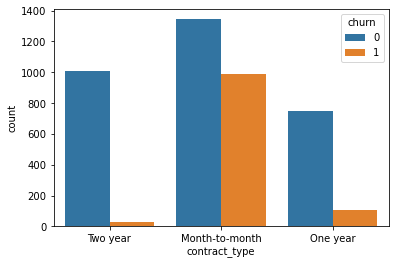

In [91]:
# bar graph of the relationship between contract type and churn

sns.countplot(x='contract_type', hue='churn', data=train_telco)

In [92]:
pd.crosstab(train_telco.contract_type, train_telco.churn)

churn,0,1
contract_type,,
Month-to-month,1344,991
One year,750,104
Two year,1010,26


In [93]:
# chi2 test of contract type and churn shows that there is a strong relationship

observed = pd.crosstab(train_telco.contract_type, train_telco.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [94]:
print('Observed')
print(observed.values)
print('\nExpected')
print(expected.astype(int))
print('\n----')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[1344  991]
 [ 750  104]
 [1010   26]]

Expected
[[1715  619]
 [ 627  226]
 [ 761  274]]

----
chi^2 = 700.1525
p     = 0.0000


<AxesSubplot:xlabel='phone_service', ylabel='count'>

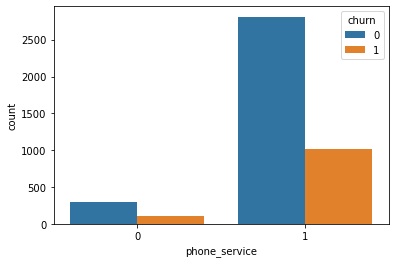

In [95]:
# bar graph of relationship between phone service and churn

sns.countplot(x='phone_service', hue='churn', data=train_telco)

In [96]:
pd.crosstab(train_telco.phone_service, train_telco.churn)

churn,0,1
phone_service,,
0,294,106
1,2810,1015


In [97]:
# chi2 test of phone service and churn shows that there is no relationship

observed = pd.crosstab(train_telco.phone_service, train_telco.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [98]:
print('Observed')
print(observed.values)
print('\nExpected')
print(expected.astype(int))
print('\n----')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[ 294  106]
 [2810 1015]]

Expected
[[ 293  106]
 [2810 1014]]

----
chi^2 = 0.0000
p     = 1.0000


<AxesSubplot:xlabel='multiple_lines', ylabel='count'>

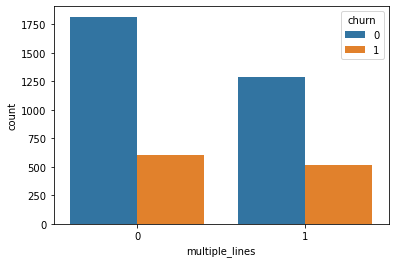

In [99]:
# bar graph of the relationship between multiple lines and churn

sns.countplot(x='multiple_lines', hue='churn', data=train_telco)

In [100]:
pd.crosstab(train_telco.multiple_lines, train_telco.churn)

churn,0,1
multiple_lines,,
0,1817,606
1,1287,515


In [101]:
# chi2 test of multiple lines and churn show a small relationship

observed = pd.crosstab(train_telco.multiple_lines, train_telco.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [102]:
print('Observed')
print(observed.values)
print('\nExpected')
print(expected.astype(int))
print('\n----')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[1817  606]
 [1287  515]]

Expected
[[1780  642]
 [1323  478]]

----
chi^2 = 6.5714
p     = 0.0104


<AxesSubplot:xlabel='paperless_billing', ylabel='count'>

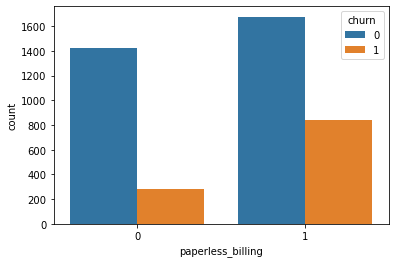

In [103]:
# bar graph of the relationship between paperless billing and churn

sns.countplot(x='paperless_billing', hue='churn', data=train_telco)

In [104]:
pd.crosstab(train_telco.paperless_billing, train_telco.churn)

churn,0,1
paperless_billing,,
0,1427,280
1,1677,841


In [105]:
# chi2 test of paperless billing and churn show that there is a relationship

observed = pd.crosstab(train_telco.paperless_billing, train_telco.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [106]:
print('Observed')
print(observed.values)
print('\nExpected')
print(expected.astype(int))
print('\n----')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[1427  280]
 [1677  841]]

Expected
[[1254  452]
 [1849  668]]

----
chi^2 = 149.8964
p     = 0.0000


<AxesSubplot:xlabel='streaming_tv', ylabel='count'>

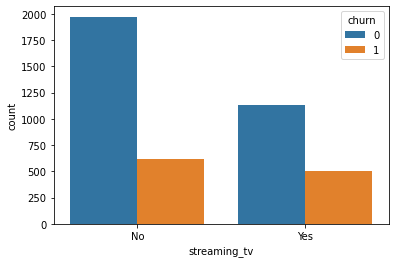

In [107]:
# bar graph of the relationship between streaming tv and churn

sns.countplot(x='streaming_tv', hue='churn', data=train_telco)

In [108]:
pd.crosstab(train_telco.streaming_tv, train_telco.churn)

churn,0,1
streaming_tv,,
No,1973,617
Yes,1131,504


In [109]:
# chi2 test of streaming tv and churn show that there is a relationship

observed = pd.crosstab(train_telco.streaming_tv, train_telco.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [110]:
print('Observed')
print(observed.values)
print('\nExpected')
print(expected.astype(int))
print('\n----')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[1973  617]
 [1131  504]]

Expected
[[1902  687]
 [1201  433]]

----
chi^2 = 24.8606
p     = 0.0000


<AxesSubplot:xlabel='streaming_movies', ylabel='count'>

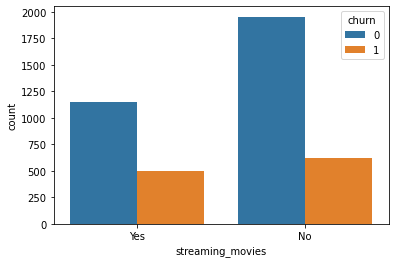

In [111]:
# chi2 test of the relationship between streaming movies and churn

sns.countplot(x='streaming_movies', hue='churn', data=train_telco)

In [112]:
pd.crosstab(train_telco.streaming_movies, train_telco.churn)

churn,0,1
streaming_movies,,
No,1953,618
Yes,1151,503


In [113]:
# chi2 test of streaming movies and churn show that there is a relationship

observed = pd.crosstab(train_telco.streaming_movies, train_telco.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [114]:
print('Observed')
print(observed.values)
print('\nExpected')
print(expected.astype(int))
print('\n----')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[1953  618]
 [1151  503]]

Expected
[[1888  682]
 [1215  438]]

----
chi^2 = 20.6507
p     = 0.0000


<AxesSubplot:xlabel='online_security', ylabel='count'>

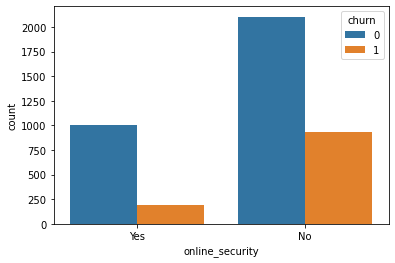

In [115]:
# bar graph of relationship between online security and churn

sns.countplot(x='online_security', hue='churn', data=train_telco)

In [116]:
pd.crosstab(train_telco.online_security, train_telco.churn)

churn,0,1
online_security,,
No,2103,931
Yes,1001,190


In [117]:
# chi2 test of online security and churn show that there is a relationship

observed = pd.crosstab(train_telco.online_security, train_telco.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [118]:
print('Observed')
print(observed.values)
print('\nExpected')
print(expected.astype(int))
print('\n----')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[2103  931]
 [1001  190]]

Expected
[[2229  804]
 [ 874  316]]

----
chi^2 = 94.4781
p     = 0.0000


<AxesSubplot:xlabel='device_protection', ylabel='count'>

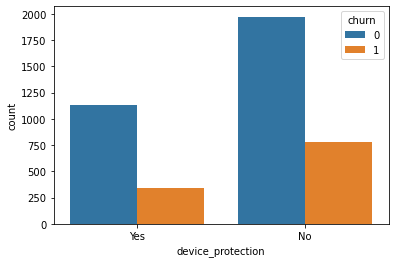

In [119]:
# bar graph of relationship between device protection and churn

sns.countplot(x='device_protection', hue='churn', data=train_telco)

In [120]:
pd.crosstab(train_telco.device_protection, train_telco.churn)

churn,0,1
device_protection,,
No,1972,783
Yes,1132,338


In [121]:
# chi2 test of device protection and churn show that there is a relationship

observed = pd.crosstab(train_telco.device_protection, train_telco.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [122]:
print('Observed')
print(observed.values)
print('\nExpected')
print(expected.astype(int))
print('\n----')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[1972  783]
 [1132  338]]

Expected
[[2024  730]
 [1079  390]]

----
chi^2 = 14.2104
p     = 0.0002


<AxesSubplot:xlabel='tech_support', ylabel='count'>

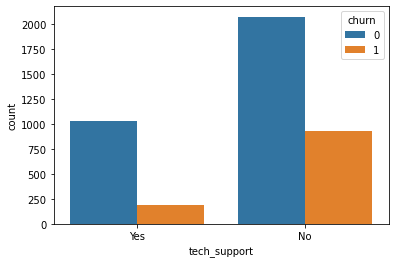

In [123]:
# bar graph of the relationship between tech support and churn

sns.countplot(x='tech_support', hue='churn', data=train_telco)

In [124]:
pd.crosstab(train_telco.tech_support, train_telco.churn)

churn,0,1
tech_support,,
No,2076,927
Yes,1028,194


In [125]:
# chi2 test of tech support and churn show that there is a relationship

observed = pd.crosstab(train_telco.tech_support, train_telco.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [126]:
print('Observed')
print(observed.values)
print('\nExpected')
print(expected.astype(int))
print('\n----')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[2076  927]
 [1028  194]]

Expected
[[2206  796]
 [ 897  324]]

----
chi^2 = 99.4012
p     = 0.0000


<AxesSubplot:xlabel='online_backup', ylabel='count'>

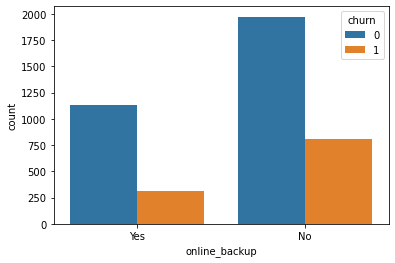

In [127]:
# bar graph of the relationship between online backup and churn

sns.countplot(x='online_backup', hue='churn', data=train_telco)

In [128]:
pd.crosstab(train_telco.online_backup, train_telco.churn)

churn,0,1
online_backup,,
No,1973,807
Yes,1131,314


In [129]:
# chi2 test of online backup and contingency show that there is a relationship

observed = pd.crosstab(train_telco.online_backup, train_telco.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [130]:
print('Observed')
print(observed.values)
print('\nExpected')
print(expected.astype(int))
print('\n----')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[1973  807]
 [1131  314]]

Expected
[[2042  737]
 [1061  383]]

----
chi^2 = 25.6106
p     = 0.0000


<AxesSubplot:xlabel='partner', ylabel='count'>

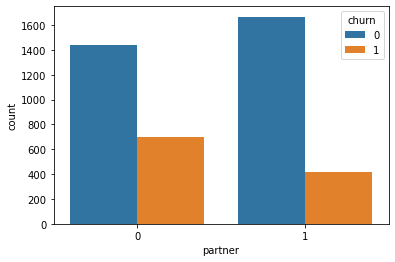

In [131]:
# bar graph of the relationship between partner and churn

sns.countplot(x='partner', hue='churn', data=train_telco)

In [132]:
pd.crosstab(train_telco.partner, train_telco.churn)

churn,0,1
partner,,
0,1437,702
1,1667,419


In [133]:
# chi2 test of partner and churn show that there is a relationship

observed = pd.crosstab(train_telco.partner, train_telco.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [134]:
print('Observed')
print(observed.values)
print('\nExpected')
print(expected.astype(int))
print('\n----')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[1437  702]
 [1667  419]]

Expected
[[1571  567]
 [1532  553]]

----
chi^2 = 87.1838
p     = 0.0000


<AxesSubplot:xlabel='dependents', ylabel='count'>

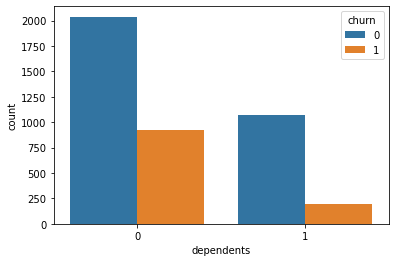

In [135]:
# bar graph of relationship between dependents and churn

sns.countplot(x='dependents', hue='churn', data=train_telco)

In [136]:
pd.crosstab(train_telco.dependents, train_telco.churn)

churn,0,1
dependents,,
0,2038,927
1,1066,194


In [137]:
# chi2 test of dependents and churn show that there is a relationship

observed = pd.crosstab(train_telco.dependents, train_telco.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [138]:
print('Observed')
print(observed.values)
print('\nExpected')
print(expected.astype(int))
print('\n----')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[2038  927]
 [1066  194]]

Expected
[[2178  786]
 [ 925  334]]

----
chi^2 = 113.4056
p     = 0.0000


#### Findings:

- The average monthly charge for customers who churned was 74.9 percent.

- Churn decreases as tenure increases.

- Senior citizens are more likely to churn than non-senior citizens.

- Customers with fiber optic internet service type are more likely to churn than no internet service and DSL.

- Customers with automatic payment are less likely to churn.

- Customers with contracts are less likely to churn than month-to-month customers.

- Customers without paperless billing appear less likely to churn.

- Customers with dependents are less likely to churn.



### Multivariate analysis

<AxesSubplot:xlabel='contract_type', ylabel='monthly_charges'>

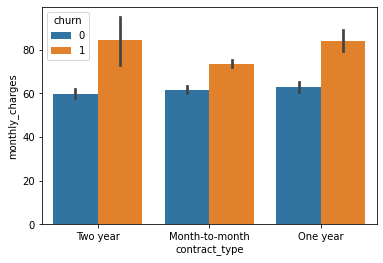

In [139]:
# barplot of contract type and monthly charges affect churn

sns.barplot(x=train_telco.contract_type, y=train_telco.monthly_charges, hue=train_telco.churn)

<AxesSubplot:xlabel='monthly_charges', ylabel='tenure'>

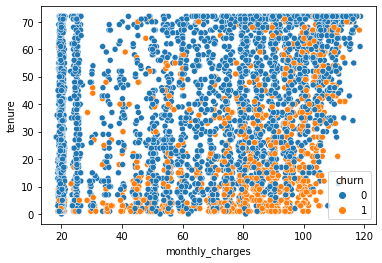

In [140]:
# scatterplot of how monthly charges and tenure affect churn

sns.scatterplot(x=train_telco.monthly_charges, y=train_telco.tenure, hue=train_telco.churn)

<AxesSubplot:xlabel='internet_service_type', ylabel='monthly_charges'>

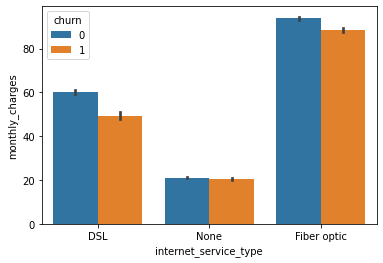

In [141]:
# bar graph of how internet service type and monthly charges affect churn

sns.barplot(x=train_telco.internet_service_type, y=train_telco.monthly_charges, hue=train_telco.churn)

<AxesSubplot:xlabel='phone_service', ylabel='tenure'>

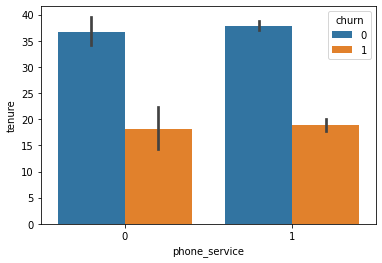

In [142]:
# bar graph of how tenure and phone service affect churn

sns.barplot(x=train_telco.phone_service, y=train_telco.tenure, hue=train_telco.churn)

<AxesSubplot:xlabel='contract_type', ylabel='tenure'>

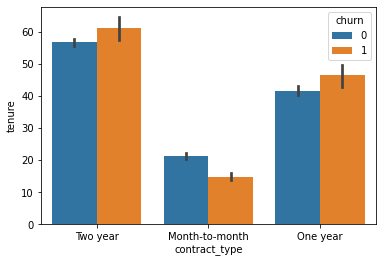

In [143]:
# bar graph of how contract type and tenure affect churn

sns.barplot(x=train_telco.contract_type, y=train_telco.tenure, hue=train_telco.churn)

<AxesSubplot:xlabel='internet_service_type', ylabel='tenure'>

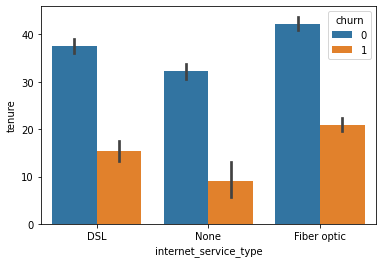

In [144]:
# bar graph of how internet service type and tenure affect churn

sns.barplot(x=train_telco.internet_service_type, y=train_telco.tenure, hue=train_telco.churn)

#### Findings:

- higher monthly charges appears to increase the likelihood of churn across all contract types.

- higher monthly charges and lower tenure appears to have a greater likelihood of churn.

- internet service type and monthly charges do not significantly affect churn



### Modeling

In [145]:
# Baseline prediction is customers do not churn

baseline = len(train_telco[train_telco.churn == 0]) / len(train_telco)
baseline

0.7346745562130178

In [146]:
# model 1 is a decision tree with a maximum depth of 4

model1 = DecisionTreeClassifier(max_depth=4)

In [147]:
# features used in the decision tree

X_col = ['tenure', 'monthly_charges', 'contract_type_id', 'internet_service_type_id', 'senior_citizen', 'partner', 'dependents']
y_col = 'churn'

In [148]:
# assign features to train variables

X_train, y_train = train_telco[X_col], train_telco[y_col]
X_validate, y_validate = validate_telco[X_col], validate_telco[y_col]

In [149]:
X_train.head()

,tenure,monthly_charges,contract_type_id,internet_service_type_id,senior_citizen,partner,dependents
621,61,80.80,3,1,0,1,0
2607,1,19.75,1,3,0,0,0
6443,1,20.30,1,3,0,0,0
409,45,78.75,2,1,0,1,1
4058,65,99.05,3,2,0,1,1


In [150]:
# fit model 1 to DecisionTreeClassifier

model1.fit(X_train, y_train)
print(f'training score: {model1.score(X_train, y_train):.2%}')
print(f'validate score: {model1.score(X_validate, y_validate):.2%}')

training score: 79.05%
validate score: 79.84%


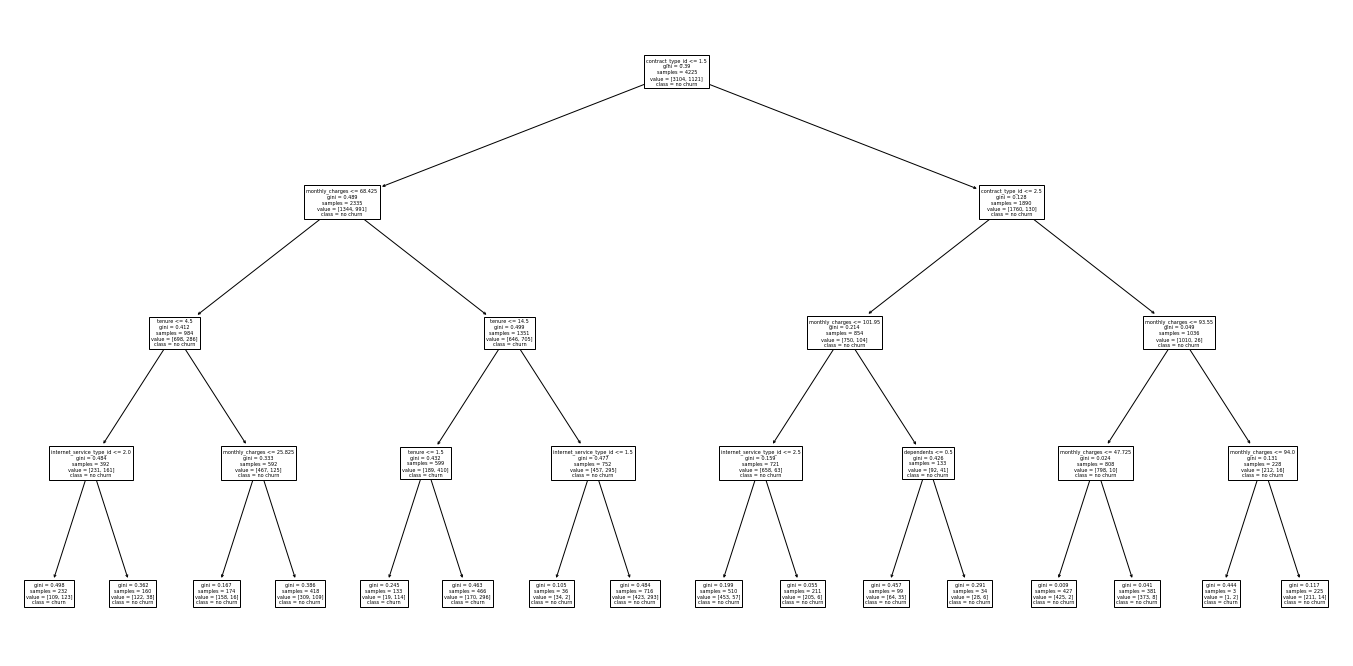

In [151]:
# visualization of model 1 decision tree

plt.figure(figsize=(24,12))
plot_tree(model1, feature_names=X_train.columns.to_list(), class_names=['no churn', 'churn']);

In [152]:
# model 1 is reassigned in order to run a random forest classifier

model1 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', min_samples_leaf=3, 
                                 n_estimators=100, max_depth=6, random_state=217)

In [153]:
# fit the model to the random forest

model1.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=3, random_state=217)

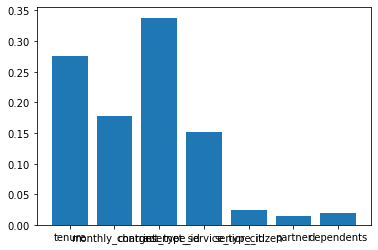

In [154]:
# feature importances bar graph; contract type has the largest value, followed by tenure and monthly charges

plt.bar(X_train.columns, model1.feature_importances_)
plt.show()

In [155]:
# assign variables for the prediction of model 1

y_pred1 = model1.predict(X_train)
y_pred_proba1 = model1.predict_proba(X_train)

# score the model and output the accuracy
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(model1.score(X_train, y_train)))
# print classification report
print(classification_report(y_train, y_pred1))

Accuracy of random forest classifier on training set: 0.81
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      3104
           1       0.69      0.49      0.57      1121

    accuracy                           0.81      4225
   macro avg       0.76      0.70      0.72      4225
weighted avg       0.79      0.81      0.79      4225



In [156]:
# assign variables for predictions against the validate dataset

y_pred1 = model1.predict(X_validate)
y_pred_proba1 = model1.predict_proba(X_validate)

# score the model and output the accuracy on the validate dataset
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(model1.score(X_validate, y_validate)))
# print the classification report for the random forest model validate dataset
print(classification_report(y_validate, y_pred1))

Accuracy of random forest classifier on test set: 0.81
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1035
           1       0.69      0.53      0.60       374

    accuracy                           0.81      1409
   macro avg       0.77      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [157]:
# create a for loop to adjust the max depth and run the model on train and validate

# empty list for the output
metrics = []

for i in range(2, 25):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=217)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first then check validate
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
# calculate the difference in accuracy between train and validate
    df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.734675,0.734564,0.000111
1,3,0.789822,0.799858,-0.010036
2,4,0.792189,0.804116,-0.011927
3,5,0.796923,0.804116,-0.007193
4,6,0.806864,0.814762,-0.007898
5,7,0.814675,0.814762,-0.000088
6,8,0.825562,0.814053,0.011510
7,9,0.845444,0.812633,0.032811
8,10,0.874793,0.805536,0.069257
9,11,0.896331,0.802697,0.093634


In [158]:
# create a for loop to adjust the minimum samples leaf at a max depth of 7

metrics = []


for i in range(2, 50):
    # Make the model
    depth = 7
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=217)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)

# calculate the difference in accuracy between train and validate    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,7,0.810651,0.809794,0.000857
1,3,7,0.808047,0.806955,0.001092
2,4,7,0.809467,0.811923,-0.002456
3,5,7,0.808994,0.810504,-0.001510
4,6,7,0.806864,0.808375,-0.001511
5,7,7,0.807101,0.809794,-0.002694
6,8,7,0.808757,0.811923,-0.003166
7,9,7,0.808757,0.814053,-0.005295
8,10,7,0.809704,0.810504,-0.000800
9,11,7,0.808284,0.810504,-0.002220


In [159]:
# create a for loop to increase both depth and minimum leaf samples

metrics = []
max_depth = 20

for i in range(2, max_depth):
    # Make the model
    depth = i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=217)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)

# calculate the difference in accuracy between train and validate
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,2,0.734675,0.734564,0.000111
1,3,3,0.790059,0.799858,-0.009799
2,4,4,0.791716,0.802697,-0.010981
3,5,5,0.795030,0.802697,-0.007667
4,6,6,0.803314,0.809084,-0.005771
5,7,7,0.807101,0.809794,-0.002694
6,8,8,0.811124,0.809794,0.001330
7,9,9,0.819172,0.809084,0.010087
8,10,10,0.819882,0.809794,0.010087
9,11,11,0.820828,0.809084,0.011744


In [160]:
# create a second model and make a decision tree using selected features

model2 = DecisionTreeClassifier(max_depth=4)
X_col2 = ['tenure', 'contract_type_id', 'dependents']
y_col2 = 'churn'

In [161]:
# assign variables to fit and train the model

X_train2, y_train2 = train_telco[X_col2], train_telco[y_col2]
X_validate2, y_validate2 = validate_telco[X_col2], validate_telco[y_col2]

In [162]:
# fit the new model to the decision tree classifier

model2.fit(X_train2, y_train2)

# score and print the accuracy against the train and validate data
print(f'training score: {model2.score(X_train2, y_train2):.2%}')
print(f'validate score: {model2.score(X_validate2, y_validate2):.2%}')

training score: 75.34%
validate score: 76.51%


In [163]:
# reassign model 2 to the random forest classifier

model2 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', min_samples_leaf=3, 
                                 n_estimators=100, max_depth=6, random_state=217)

In [164]:
# fit the model using the model 2 variables

model2.fit(X_train2, y_train2)

RandomForestClassifier(max_depth=6, min_samples_leaf=3, random_state=217)

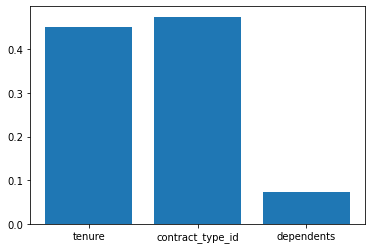

In [165]:
# graph the feature importances; tenure and contract_type_id have a much larger affect than dependents

plt.bar(X_train2.columns, model2.feature_importances_)
plt.show()

In [166]:
# assign variables for the predictions

y_pred2 = model2.predict(X_train2)
y_pred_proba2 = model2.predict_proba(X_train2)

# score and print the accuracy of model 2 on the train data
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(model2.score(X_train2, y_train2)))
# print the classification report for the model on train
print(classification_report(y_train2, y_pred2))

Accuracy of random forest classifier on training set: 0.76
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      3104
           1       0.57      0.38      0.46      1121

    accuracy                           0.76      4225
   macro avg       0.69      0.64      0.65      4225
weighted avg       0.74      0.76      0.74      4225



In [167]:
# assign variables for the predictions to be used on the validate dataset

y_pred2 = model2.predict(X_validate2)
y_pred_proba2 = model2.predict_proba(X_validate2)

# score and print the accuracy of model 2 on validate
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(model2.score(X_validate2, y_validate2)))
# print the classification report for model 2's performance on validate
print(classification_report(y_validate2, y_pred2))

Accuracy of random forest classifier on test set: 0.76
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1035
           1       0.58      0.40      0.47       374

    accuracy                           0.76      1409
   macro avg       0.69      0.65      0.66      1409
weighted avg       0.75      0.76      0.75      1409



In [168]:
# assign model 3 to a decision tree classifier with a max depth of 6

model3 = DecisionTreeClassifier(max_depth=6)

In [169]:
# features to be used in model 3

X_col3 = ['tenure', 'monthly_charges', 'payment_type_id', 'contract_type_id', 'internet_service_type_id']
y_col3 = 'churn'

In [170]:
# assign variables for train and validate

X_train3, y_train3 = train_telco[X_col3], train_telco[y_col3]
X_validate3, y_validate3 = validate_telco[X_col3], validate_telco[y_col3]

In [171]:
# fit the model using the model 3 variables

model3.fit(X_train3, y_train3)

# score and print the accuracy of model 3 on train and validate
print(f'training score: {model3.score(X_train3, y_train3):.2%}')
print(f'validate score: {model3.score(X_validate3, y_validate3):.2%}')

training score: 80.54%
validate score: 79.21%


In [172]:
# reassign model 3 to a random forest classifier

model3 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', min_samples_leaf=8, 
                                 n_estimators=100, max_depth=12, random_state=217)

In [173]:
# fit the model using model 3 variables

model3.fit(X_train3, y_train3)

RandomForestClassifier(max_depth=12, min_samples_leaf=8, random_state=217)

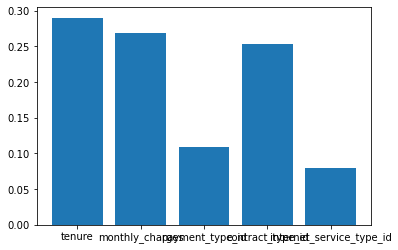

In [174]:
# bar graph of model 3's feature importances; contract_type_id, tenure, and monthly charges have the highest values

plt.bar(X_train3.columns, model3.feature_importances_)
plt.show()

In [175]:
# assign variables for the predictions

y_pred3 = model3.predict(X_train3)
y_pred_proba3 = model3.predict_proba(X_train3)

# score and print the accuracy of model 3 on train
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(model3.score(X_train3, y_train3)))
# print the classification report for model 3's performance on train
print(classification_report(y_train3, y_pred3))

Accuracy of random forest classifier on training set: 0.84
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      3104
           1       0.75      0.58      0.65      1121

    accuracy                           0.84      4225
   macro avg       0.80      0.75      0.77      4225
weighted avg       0.83      0.84      0.83      4225



In [176]:
# assign variables for predictions on validate

y_pred3 = model3.predict(X_validate3)
y_pred_proba3 = model3.predict_proba(X_validate3)

# score and print the accuracy of model 3 on validate
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(model3.score(X_validate3, y_validate3)))
print(classification_report(y_validate3, y_pred3))

Accuracy of random forest classifier on test set: 0.81
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1035
           1       0.68      0.56      0.61       374

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.75      1409
weighted avg       0.80      0.81      0.81      1409



In [177]:
# create a for loop to increase both depth and minimum leaf samples

metrics = []
max_depth = 20

for i in range(2, max_depth):
    # Make the model
    depth = i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=217)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train3, y_train3)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train3, y_train3)
    
    out_of_sample_accuracy = forest.score(X_validate3, y_validate3)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)

# calculate the difference in accuracy between train and validate
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,2,0.773491,0.782825,-0.009334
1,3,3,0.789349,0.801278,-0.011928
2,4,4,0.795740,0.803407,-0.007667
3,5,5,0.801420,0.804826,-0.003406
4,6,6,0.805444,0.806955,-0.001512
5,7,7,0.814911,0.811214,0.003698
6,8,8,0.820592,0.809794,0.010798
7,9,9,0.825562,0.811214,0.014349
8,10,10,0.826509,0.812633,0.013876
9,11,11,0.826272,0.806955,0.019317


#### Do extra services affect churn?

- I'm combining the extra internet service features (not including streaming) and adding the total number of services each customer has. This sum will be captured in a new column called 'extras'.

In [178]:
# create a new dataframe with the extra services features

telco_melt_df = pd.DataFrame([telco.customer_id, telco.online_backup, telco.online_security, telco.device_protection, telco.tech_support, telco.streaming_tv, telco.streaming_movies]).T

In [179]:
telco_melt_df.head()

,customer_id,online_backup,online_security,device_protection,tech_support,streaming_tv,streaming_movies
0,0002-ORFBO,Yes,No,No,Yes,Yes,No
1,0003-MKNFE,No,No,No,No,No,Yes
2,0004-TLHLJ,No,No,Yes,No,No,No
3,0011-IGKFF,Yes,No,Yes,No,Yes,Yes
4,0013-EXCHZ,No,No,No,Yes,Yes,No


In [180]:
# encode the extra features columns for analysis

telco_melt_df['online_security'] = telco_melt_df.online_security.map({'Yes': 1, 'No': 0})
telco_melt_df['online_backup'] = telco_melt_df.online_backup.map({'Yes': 1, 'No': 0})
telco_melt_df['device_protection'] = telco_melt_df.device_protection.map({'Yes': 1, 'No': 0})
telco_melt_df['tech_support'] = telco_melt_df.tech_support.map({'Yes': 1, 'No': 0})
telco_melt_df['streaming_tv'] = telco_melt_df.streaming_tv.map({'Yes': 1, 'No': 0})
telco_melt_df['streaming_movies'] = telco_melt_df.streaming_movies.map({'Yes': 1, 'No': 0})

In [181]:
telco_melt_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        7043 non-null   object
 1   online_backup      7043 non-null   int64 
 2   online_security    7043 non-null   int64 
 3   device_protection  7043 non-null   int64 
 4   tech_support       7043 non-null   int64 
 5   streaming_tv       7043 non-null   int64 
 6   streaming_movies   7043 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 698.2+ KB


In [182]:
# create a new column called 'extras' that contains the number of extra services each customer has

telco_melt_df['extras'] = telco_melt_df.online_backup + telco_melt_df.online_security + telco_melt_df.device_protection + telco_melt_df.tech_support

In [183]:
telco_melt_df['streaming'] = telco_melt_df.streaming_tv + telco_melt_df.streaming_movies

In [184]:
telco_melt_df

,customer_id,online_backup,online_security,device_protection,tech_support,streaming_tv,streaming_movies,extras,streaming
0,0002-ORFBO,1,0,0,1,1,0,2,1
1,0003-MKNFE,0,0,0,0,0,1,0,1
2,0004-TLHLJ,0,0,1,0,0,0,1,0
3,0011-IGKFF,1,0,1,0,1,1,2,2
4,0013-EXCHZ,0,0,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,0,1,0,1,0,0,2,0
7039,9992-RRAMN,0,0,0,0,0,1,0,1
7040,9992-UJOEL,1,0,0,0,0,0,1,0
7041,9993-LHIEB,0,1,1,1,0,1,3,1


In [185]:
# concatenate the two dataframes to add the extra columns to the telco data

telco_concat = pd.concat([telco, telco_melt_df], axis=1)

In [186]:
telco_concat.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,payment_type,customer_id,online_backup,online_security,device_protection,tech_support,streaming_tv,streaming_movies,extras,streaming
0,2,1,2,0002-ORFBO,0,0,1,1,9,1,...,manual,0002-ORFBO,1,0,0,1,1,0,2,1
1,2,1,1,0003-MKNFE,1,0,0,0,9,1,...,manual,0003-MKNFE,0,0,0,0,0,1,0,1
2,1,2,1,0004-TLHLJ,1,0,0,0,4,1,...,manual,0004-TLHLJ,0,0,1,0,0,0,1,0
3,1,2,1,0011-IGKFF,1,1,1,0,13,1,...,manual,0011-IGKFF,1,0,1,0,1,1,2,2
4,2,2,1,0013-EXCHZ,0,1,1,0,3,1,...,manual,0013-EXCHZ,0,0,0,1,1,0,1,1


In [187]:
telco_concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   int64  
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   int64  
 7   dependents                7043 non-null   int64  
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   int64  
 10  multiple_lines            7043 non-null   int64  
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [188]:
# split the data using the data_split function in the prepare.py file
# assign new variables with this concatenated data so that the other data from previous modeling is preserved

train_telco_concat, validate_telco_concat, test_telco_concat = prepare.split_data(telco_concat, 'churn')

<AxesSubplot:xlabel='extras', ylabel='count'>

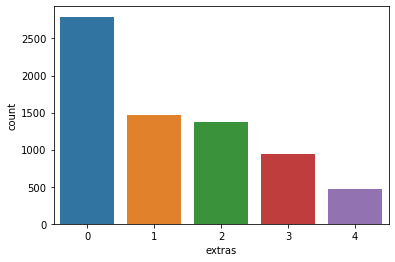

In [189]:
# bar graph of the number of customers who have extra features

sns.countplot(x='extras', data=telco_concat)

In [190]:
# a cross-tabulation of how extra services affect churn

pd.crosstab(train_telco_concat.extras, train_telco_concat.churn)

churn,0,1
extras,,
0,1189,493
1,542,328
2,622,207
3,498,78
4,253,15


<AxesSubplot:xlabel='extras', ylabel='count'>

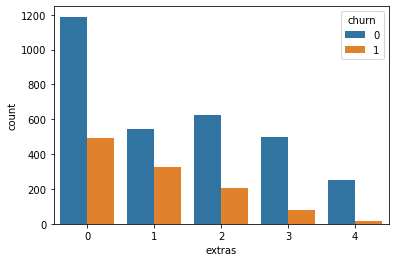

In [191]:
# bar graph of the relationship between extra services and churn; customers with all four services appear to have
# the lowest churn rate

sns.countplot(x='extras', hue='churn', data=train_telco_concat)

<AxesSubplot:xlabel='streaming', ylabel='count'>

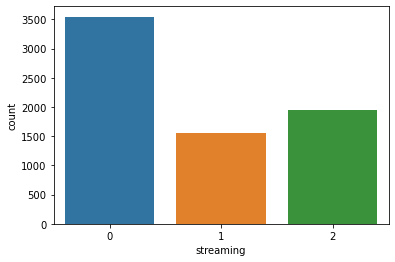

In [192]:
sns.countplot(x='streaming', data=telco_concat)

In [193]:
pd.crosstab(train_telco_concat.streaming, train_telco_concat.churn)

churn,0,1
streaming,,
0,1644,468
1,638,299
2,822,354


<AxesSubplot:xlabel='streaming', ylabel='count'>

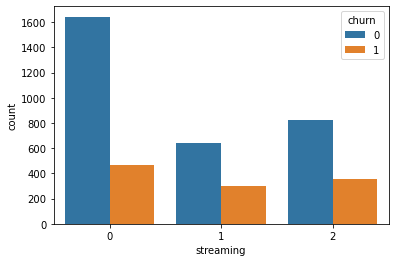

In [194]:
sns.countplot(x='streaming', hue='churn', data=train_telco_concat)

In [195]:
# chi2 test of the extra services and churn to calculate a potential relationship; the test determined that there is
# indeed a relationship between the two features

observed = pd.crosstab(train_telco_concat.extras, train_telco_concat.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [196]:
print('Observed')
print(observed.values)
print('\nExpected')
print(expected.astype(int))
print('\n----')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[1189  493]
 [ 542  328]
 [ 622  207]
 [ 498   78]
 [ 253   15]]

Expected
[[1235  446]
 [ 639  230]
 [ 609  219]
 [ 423  152]
 [ 196   71]]

----
chi^2 = 173.4979
p     = 0.0000


In [197]:
observed = pd.crosstab(train_telco_concat.streaming, train_telco_concat.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print('Observed')
print(observed.values)
print('\nExpected')
print(expected.astype(int))
print('\n----')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[1644  468]
 [ 638  299]
 [ 822  354]]

Expected
[[1551  560]
 [ 688  248]
 [ 863  312]]

----
chi^2 = 42.3126
p     = 0.0000


In [198]:
# assign a new model to a decision tree classifier with a max depth of 6

model4 = DecisionTreeClassifier(max_depth=5)

In [202]:
# assign variables for the features to be used in model 4

X_col4 = ['tenure', 'monthly_charges', 'internet_service_type_id', 'extras', 'streaming', 'paperless_billing', 'senior_citizen', 'dependents', 'partner']
y_col4 = 'churn'

In [203]:
# assign variables to train and validate the model

X_train4, y_train4 = train_telco_concat[X_col4], train_telco_concat[y_col4]
X_validate4, y_validate4 = validate_telco_concat[X_col4], validate_telco_concat[y_col4]

In [204]:
# fit model 4 using the assigned variables

model4.fit(X_train4, y_train4)

# score and print the accuracy of model 4 on train
print(f'training score: {model4.score(X_train4, y_train4):.2%}')
# score and print the accuray of model 4 on validate
print(f'validate score: {model4.score(X_validate4, y_validate4):.2%}')

training score: 79.64%
validate score: 79.21%


In [205]:
# reassign model 4 to a random forest classifier

model4 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini', min_samples_leaf=14, 
                                 n_estimators=100, max_depth=14, random_state=217)

In [206]:
# fit the model with the assigned variables for model 4

model4.fit(X_train4, y_train4)

RandomForestClassifier(max_depth=14, min_samples_leaf=14, random_state=217)

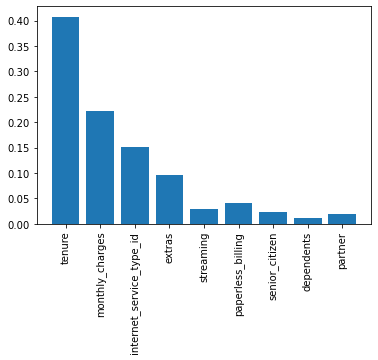

In [207]:
# bar graph of feature importances; extras has a higher importance than senior citizen, partner, and dependents

plt.bar(X_train4.columns, model4.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [208]:
# assign variables to predictions

y_pred4 = model4.predict(X_train4)
y_pred_proba4 = model4.predict_proba(X_train4)

# score and print model 4's accuracy on train
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(model4.score(X_train4, y_train4)))
# print the classification report of model 4's performance on train
print(classification_report(y_train4, y_pred4))

Accuracy of random forest classifier on training set: 0.82
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      3104
           1       0.73      0.51      0.60      1121

    accuracy                           0.82      4225
   macro avg       0.78      0.72      0.74      4225
weighted avg       0.81      0.82      0.81      4225



In [209]:
# assign variables to predictions for validate

y_pred4 = model4.predict(X_validate4)
y_pred_proba4 = model4.predict_proba(X_validate4)

# score and print model 4's accuracy on validate
print('Accuracy of random forest classifier on validate set: {:.2f}'
     .format(model4.score(X_validate4, y_validate4)))
# print the classification report of model 4's performance on validate
print(classification_report(y_validate4, y_pred4))

Accuracy of random forest classifier on validate set: 0.82
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1035
           1       0.71      0.51      0.60       374

    accuracy                           0.82      1409
   macro avg       0.78      0.72      0.74      1409
weighted avg       0.81      0.82      0.80      1409



In [210]:
# assign variables to features and train/validate

#X_col = ['tenure', 'monthly_charges', 'dependents', 'contract_type_id', 'extras', 'internet_service_type_id', 'payment_type_id', 'partner', 'senior_citizen']
#y_col = 'churn'
X_train4, y_train4 = train_telco_concat[X_col4], train_telco_concat[y_col4]
X_validate4, y_validate4 = validate_telco_concat[X_col4], validate_telco_concat[y_col4]

In [211]:
# create a for loop to calculate accuracy of this model at different max depths

metrics = []

for i in range(1, 25):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=217)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train4, y_train4)

    # Use the model
    # We'll evaluate the model's performance on train, first then check validate
    in_sample_accuracy = forest.score(X_train4, y_train4)
    
    out_of_sample_accuracy = forest.score(X_validate4, y_validate4)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)

# calculate the difference between train and validate accuracy
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,1,0.734675,0.734564,0.000111
1,2,0.737278,0.736693,0.000585
2,3,0.787219,0.789922,-0.002703
3,4,0.794083,0.804116,-0.010034
4,5,0.798107,0.810504,-0.012397
5,6,0.806391,0.811923,-0.005533
6,7,0.825089,0.815472,0.009617
7,8,0.838107,0.811923,0.026183
8,9,0.860355,0.810504,0.049851
9,10,0.888757,0.801278,0.087480


In [212]:
# create a for loop to print the classification reports of this model at different depths

for i in range(2, 14):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=217)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train4, y_train4)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = forest.predict(X_train4)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train4, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
                     0            1  accuracy    macro avg  weighted avg
precision     0.736592     1.000000  0.737278     0.868296      0.806481
recall        1.000000     0.009813  0.737278     0.504906      0.737278
f1-score      0.848319     0.019435  0.737278     0.433877      0.628395
support    3104.000000  1121.000000  0.737278  4225.000000   4225.000000

Tree with max depth of 3
                     0            1  accuracy    macro avg  weighted avg
precision     0.793296     0.738197  0.787219     0.765747      0.778677
recall        0.960696     0.306869  0.787219     0.633782      0.787219
f1-score      0.869008     0.433522  0.787219     0.651265      0.753462
support    3104.000000  1121.000000  0.787219  4225.000000   4225.000000

Tree with max depth of 4
                     0            1  accuracy    macro avg  weighted avg
precision     0.809590     0.703404  0.794083     0.756497      0.781416
recall        0.941044     0.387154  0.794083  

In [213]:
# create a for loop to calculate the accuracy of the model at different minimum samples leaf

metrics = []


for i in range(2, 25):
    # Make the model
    depth = 15
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=217)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train4, y_train4)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train4, y_train4)
    
    out_of_sample_accuracy = forest.score(X_validate4, y_validate4)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
# calculate the difference in accuracy between train and validate
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,15,0.919763,0.798439,0.121325
1,3,15,0.887574,0.804826,0.082748
2,4,15,0.871953,0.803407,0.068546
3,5,15,0.860592,0.806246,0.054346
4,6,15,0.851598,0.809084,0.042513
5,7,15,0.848994,0.805536,0.043458
6,8,15,0.840000,0.809084,0.030916
7,9,15,0.835740,0.805536,0.030204
8,10,15,0.832189,0.809794,0.022395
9,11,15,0.829112,0.811923,0.017189


In [214]:
# create a for loop to calculate the model's accuracy at increasing depths and sample leaves

metrics = []
max_depth = 50

for i in range(1, max_depth):
    # Make the model
    depth = i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=217)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train4, y_train4)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train4, y_train4)
    
    out_of_sample_accuracy = forest.score(X_validate4, y_validate4)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)

# calculate the difference in accuracy between train and validate for each iteration
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,1,1,0.734675,0.734564,0.000111
1,2,2,0.737278,0.736693,0.000585
2,3,3,0.787219,0.789922,-0.002703
3,4,4,0.794320,0.804826,-0.010507
4,5,5,0.797160,0.809794,-0.012634
5,6,6,0.804970,0.813343,-0.008372
6,7,7,0.812544,0.814762,-0.002218
7,8,8,0.820828,0.811214,0.009615
8,9,9,0.826746,0.813343,0.013403
9,10,10,0.827929,0.811923,0.016006


In [215]:
# create a for loop to calculate the accuracy of the model as depth increases and sample leaves increases

metrics = []
max_depth = 14

for i in range(2, max_depth):
    # Make the model
    depth = i
    n_samples = max_depth - i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=217)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train4, y_train4)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train4, y_train4)
    
    out_of_sample_accuracy = forest.score(X_validate4, y_validate4)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
# calculate the difference between train and validate accuracy for each iteration
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,12,2,0.737278,0.736693,0.000585
1,11,3,0.787219,0.789922,-0.002703
2,10,4,0.794793,0.803407,-0.008614
3,9,5,0.797633,0.809084,-0.011451
4,8,6,0.805444,0.812633,-0.007189
5,7,7,0.812544,0.814762,-0.002218
6,6,8,0.823432,0.809084,0.014347
7,5,9,0.837870,0.811214,0.026656
8,4,10,0.853491,0.803407,0.050084
9,3,11,0.871243,0.799148,0.072094


In [216]:
# assign a variable to K neighbors classifier with default values

knn = KNeighborsClassifier(n_neighbors=48, weights='uniform')

In [217]:
# fit the knn model using model 4's variables

knn.fit(X_train4, y_train4)

KNeighborsClassifier(n_neighbors=48)

In [218]:
# calculate a prediction of this model and assign it to y_pred

y_pred = knn.predict(X_train4)

In [219]:
# score and print the accuracy of this model on train

print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train4, y_train4)))

Accuracy of KNN classifier on training set: 0.80


In [220]:
# print the classification report of the knn model's performance on train

print(classification_report(y_train4, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      3104
           1       0.70      0.41      0.52      1121

    accuracy                           0.80      4225
   macro avg       0.76      0.67      0.70      4225
weighted avg       0.78      0.80      0.78      4225



In [221]:
# assign variable to the predictions of the knn model on validate

y_pred = knn.predict(X_validate4)

# score and print the knn model's accuracy on the validate set
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_validate4, y_validate4)))

Accuracy of KNN classifier on test set: 0.79


In [222]:
# create a for loop to run the knn model at different neighbor values

metrics = []

for i in range(1, 51, 2):
    # Make the model
    k_telco = KNeighborsClassifier(n_neighbors=i)

    # Fit the model (on train and only train)
    k_telco = k_telco.fit(X_train4, y_train4)

    # Use the model
    # We'll evaluate the model's performance on train, first then check validate
    in_sample_accuracy = k_telco.score(X_train4, y_train4)
    
    out_of_sample_accuracy = k_telco.score(X_validate4, y_validate4)

    output = {
        "neighbors": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)

# calculate the difference in accuracy between train and validate for each iteration
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,neighbors,train_accuracy,validate_accuracy,difference
0,1,0.995503,0.737402,0.258101
1,3,0.863905,0.761533,0.102372
2,5,0.837870,0.766501,0.071369
3,7,0.826036,0.776437,0.049598
4,9,0.819172,0.787793,0.031379
5,11,0.814675,0.787083,0.027592
6,13,0.811124,0.787793,0.023331
7,15,0.808284,0.792051,0.016233
8,17,0.804970,0.799148,0.005822
9,19,0.805207,0.797019,0.008188


In [223]:
# assign a model to logistic regression

logit = LogisticRegression(random_state=217, max_iter=200, solver='lbfgs')

In [224]:
# assign variables to the features to be used in logit

X_col5 = ['tenure', 'monthly_charges', 'internet_service_type_id', 'contract_type_id', 'paperless_billing', 'extras', 'payment_type_id', 'dependents', 'streaming', 'partner', 'senior_citizen']
y_col5 = 'churn'

# assign variables to train and validate the model
X_train5, y_train5 = train_telco_concat[X_col5], train_telco_concat[y_col5]
X_validate5, y_validate5 = validate_telco_concat[X_col5], validate_telco_concat[y_col5]

In [225]:
# fit the model using the previously assigned variables

logit.fit(X_train5, y_train5)

LogisticRegression(max_iter=200, random_state=217)

In [226]:
# print the coefficients for each feature and the intercept

print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-0.02866811  0.02534716 -0.19216514 -0.84099921  0.38750905 -0.28495282
  -0.14313831 -0.20842087  0.13089884  0.03295982  0.28727579]]
Intercept: 
 [-0.18283333]


In [227]:
# assign variables to predictions for model 5

y_pred5 = logit.predict(X_train5)
y_pred_proba5 = logit.predict_proba(X_train5)

In [228]:
# score and print the accuracy of logit on train

print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train5, y_train5)))

Accuracy of Logistic Regression classifier on training set: 0.80


In [229]:
print(confusion_matrix(y_train5, y_pred5))

[[2786  318]
 [ 542  579]]


In [230]:
# assign variables to predictions for validate

y_pred5 = logit.predict(X_validate5)

print("Model 5: solver = lbfgs, c = 1")

# accuracy of model 5
print('Accuracy: {:.2f}'.format(logit.score(X_validate5, y_validate5)))

# confusion matrix of model 5
print(confusion_matrix(y_validate5, y_pred5))

# classification report of model 5
print(classification_report(y_validate5, y_pred5))

Model 5: solver = lbfgs, c = 1
Accuracy: 0.81
[[935 100]
 [168 206]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1035
           1       0.67      0.55      0.61       374

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [231]:
model6 = DecisionTreeClassifier(max_depth=5)

In [232]:
X_col6 = ['tenure', 'contract_type_id', 'monthly_charges', 'internet_service_type_id', 'paperless_billing', 'payment_type_id', 'extras', 'senior_citizen', 'streaming', 'partner', 'dependents']
y_col6 = 'churn'
X_train6, y_train6 = train_telco_concat[X_col6], train_telco_concat[y_col6]
X_validate6, y_validate6 = validate_telco_concat[X_col6], validate_telco_concat[y_col6]

In [233]:
model6.fit(X_train6, y_train6)

DecisionTreeClassifier(max_depth=5)

In [234]:
y_pred6 = model6.predict(X_train6)
print(f'training score: {model6.score(X_train6, y_train6):.2%}')
print(classification_report(y_train6, y_pred6))

training score: 79.81%
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      3104
           1       0.64      0.54      0.59      1121

    accuracy                           0.80      4225
   macro avg       0.74      0.72      0.73      4225
weighted avg       0.79      0.80      0.79      4225



In [235]:
y_pred6 = model6.predict(X_validate6)
print(f'validate score: {model6.score(X_validate6, y_validate6):.2%}')
print(classification_report(y_validate6, y_pred6))

validate score: 79.49%
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.54      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.79      0.79      1409



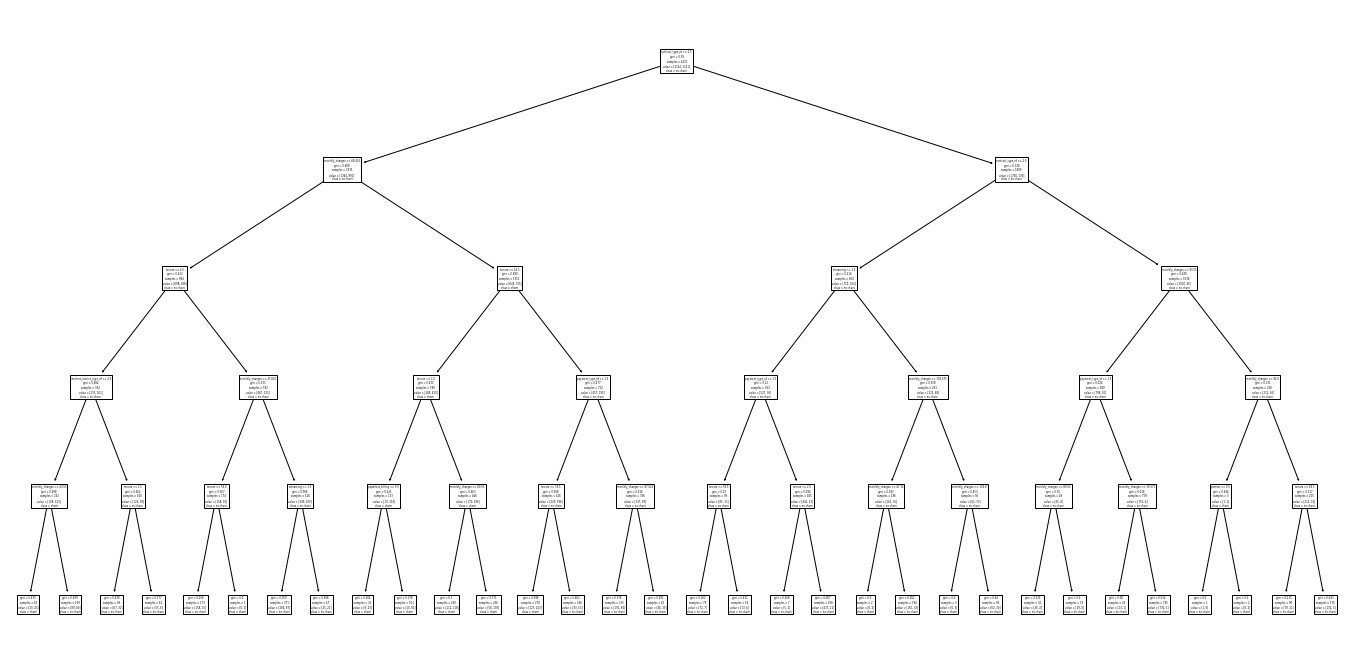

In [236]:
plt.figure(figsize=(24,12))
plot_tree(model6, feature_names=X_train6.columns.to_list(), class_names=['no churn', 'churn']);

In [237]:
logit2 = LogisticRegression(random_state=217, max_iter=200, solver='lbfgs')

In [238]:
# assign variables to the features to be used in logit

X_col7 = ['tenure', 'monthly_charges', 'contract_type_id', 'paperless_billing']
y_col7 = 'churn'

# assign variables to train and validate the model
X_train7, y_train7 = train_telco_concat[X_col7], train_telco_concat[y_col7]
X_validate7, y_validate7 = validate_telco_concat[X_col7], validate_telco_concat[y_col7]

In [239]:
# fit the model using the previously assigned variables

logit2.fit(X_train7, y_train7)

LogisticRegression(max_iter=200, random_state=217)

In [240]:
# print the coefficients for each feature and the intercept

print('Coefficient: \n', logit2.coef_)
print('Intercept: \n', logit2.intercept_)

Coefficient: 
 [[-0.03384222  0.02592117 -1.0132798   0.46624922]]
Intercept: 
 [-0.75911712]


In [241]:
# assign variables to predictions for model 7

y_pred7 = logit2.predict(X_train7)
y_pred_proba7 = logit2.predict_proba(X_train7)

In [242]:
# score and print the accuracy of logit on train

print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit2.score(X_train7, y_train7)))

Accuracy of Logistic Regression classifier on training set: 0.79


In [243]:
print(confusion_matrix(y_train7, y_pred7))

[[2782  322]
 [ 581  540]]


In [244]:
# assign variables to predictions for validate

y_pred7 = logit2.predict(X_validate7)

print("Model 7: solver = lbfgs, c = 1")

# accuracy of model 7
print('Accuracy: {:.2f}'.format(logit2.score(X_validate7, y_validate7)))

# confusion matrix of model 7
print(confusion_matrix(y_validate7, y_pred7))

# classification report of model 7
print(classification_report(y_validate7, y_pred7))

Model 7: solver = lbfgs, c = 1
Accuracy: 0.80
[[927 108]
 [176 198]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.53      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



#### Modeling Findings:

- Decision Tree model performed at 80 percent accuracy with the selected features. The maximum depth of 5 produced the least amount of overfitting.

- Random Forest performed at 80-82 percent accuracy depending on the maximum depth and minimum number of samples per leaf. The combination with the best accuracy and the lowest difference between train and validate is a maximum depth of 14 and a minimum of 14 samples per leaf. 

- The K nearest neighbors model performed at 80 percent accuracy with less than 1 percent difference in accuracy between train and validate. This model works best with 48 neighbors and uniform weights.

- Logistic regression performed at 80 percent accuracy with selected features and 200 maximum iterations. This is the only model that performed better on validate than on train.

- Since this project focuses on accuracy, I will choose the random forest model for testing.

In [245]:
# using random forest model (model 4)

y_pred = model4.predict(X_validate4)
y_pred_proba = model4.predict_proba(X_train4)

y_pred_proba = pd.DataFrame(y_pred_proba, columns = ['no churn', 'churn'])
y_pred_proba.head()

,no churn,churn
0,0.976667,0.023333
1,0.773481,0.226519
2,0.736519,0.263481
3,0.932548,0.067452
4,0.889001,0.110999


In [246]:
t = 0.5

# masking: True or False, is the predicted probability of our positive class
# greater than this new probability threshold? if yes, return True/1. Cast this as
# integer type, to receive the same types of prediction that we have previously
y_pred = (y_pred_proba.churn > t).astype(int)
y_pred.head()

0    0
1    0
2    0
3    0
4    0
Name: churn, dtype: int64

In [247]:
from sklearn.metrics import accuracy_score

In [248]:
accuracy_score(y_train4, y_pred)

0.8194082840236686

In [249]:
np.arange(0,1,.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [250]:
# lets think about thresholds in loops:
model_scores = {}
for i in np.arange(0,1,.1):
    y_pred = (y_pred_proba.churn > i).astype(int)
    accuracy = accuracy_score(y_train4, y_pred)
    model_scores[f'threshold {i}'] =  accuracy

In [251]:
model_scores

{'threshold 0.0': 0.26532544378698225,
 'threshold 0.1': 0.5732544378698224,
 'threshold 0.2': 0.7197633136094674,
 'threshold 0.30000000000000004': 0.7881656804733728,
 'threshold 0.4': 0.8184615384615385,
 'threshold 0.5': 0.8194082840236686,
 'threshold 0.6000000000000001': 0.802603550295858,
 'threshold 0.7000000000000001': 0.783905325443787,
 'threshold 0.8': 0.7555029585798817,
 'threshold 0.9': 0.7346745562130178}

### Test the Best Model

In [252]:
X_test, y_test = test_telco_concat[X_col4], test_telco_concat[y_col4]
y_pred = model4.predict(X_test)
y_pred_proba = model4.predict_proba(X_test)

In [253]:
print('Accuracy: {:.2f}'.format(model4.score(X_test, y_test)))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

Accuracy: 0.80
[[946  89]
 [194 180]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.67      0.48      0.56       374

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.71      1409
weighted avg       0.79      0.80      0.79      1409



In [254]:
y_pred_proba = np.array([i[1] for i in y_pred_proba])

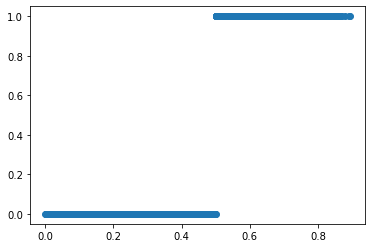

In [255]:
fig = plt.figure()
ax = fig.add_subplot(111)

# scatter plot where x is the probabilities and y is the class (0, 1)
ax.scatter(y_pred_proba, y_pred)